## Exploring a public Web server log dataset using Apache Spark

## Part 2: Using SparkSQL and data frames to look into the data.

This notebook uses the Parquet data store created previously [[here]](https://github.com/sgcom/spark-web-log-analysis/blob/master/UofS_Logs_1_ETL.ipynb). 

#### Dataset source: http://ita.ee.lbl.gov/html/contrib/Sask-HTTP.html, available from [The Internet Traffic Archive](http://ita.ee.lbl.gov/index.html).

#### Dataset description:

This trace contains seven months’ worth of all HTTP requests to the University of Saskatchewan's WWW server. The University of Saskatchewan is located in Saskatoon, Saskatchewan, Canada.

The log contains over **_2,400,000_** lines from **_June to December 1995_** - the early days of the World Wide Web.

### Initialize the Apache Spark context ; check out the Spark version and config.

In [1]:
## Initialize
#
import findspark
import os
findspark.init()

import pyspark
sc = pyspark.SparkContext()

In [2]:
# Check the Spark context & config
#
sc.version, sc._conf.getAll()

(u'1.5.0',
 [(u'spark.driver.memory', u'6g'),
  (u'spark.rdd.compress', u'True'),
  (u'spark.master', u'local[8]'),
  (u'spark.serializer.objectStreamReset', u'100'),
  (u'spark.submit.deployMode', u'client'),
  (u'spark.app.name', u'pyspark-shell')])

### Python imports and global settings

In [3]:
import re
import math
import time, datetime
import os
import operator as op
from pyspark import *
from pyspark.sql import Row, SQLContext
import matplotlib.pyplot as plt

outputDir = './output'
%precision 2
%matplotlib inline

### Helpers

In [4]:
import csv

def write_to_csv( file_name, header, values_list ):
    csv_file = os.path.join(outputDir, file_name)
    with open(csv_file, 'wb') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csvwriter.writerow(header)
        for v in values_list:
            csvwriter.writerow(v)
            
week_day_map = { 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat', 7:'Sun' }

### Read from the Parquet format and register table

In [5]:
sqlContext = SQLContext(sc)
weblogDf = sqlContext.read.parquet("data/UofS_access_log.parquet")
weblogDf.registerTempTable("weblog");
weblogDf.printSchema()

root
 |-- date: date (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- day: long (nullable = true)
 |-- epo_seconds: double (nullable = true)
 |-- hours: long (nullable = true)
 |-- http_status: long (nullable = true)
 |-- http_verb: string (nullable = true)
 |-- minutes: long (nullable = true)
 |-- month: long (nullable = true)
 |-- quarter_hour: double (nullable = true)
 |-- remote_host: string (nullable = true)
 |-- resp_size: long (nullable = true)
 |-- url: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- week_day: long (nullable = true)
 |-- year: long (nullable = true)



#### Count of records - dataframe version.

In [6]:
% time weblogDf.count()

CPU times: user 998 µs, sys: 184 µs, total: 1.18 ms
Wall time: 1.03 s


2408580

#### Count of records - SQL version.

In [7]:
%time sqlContext.sql("SELECT COUNT(*) AS count FROM weblog").collect()

CPU times: user 3.08 ms, sys: 19 µs, total: 3.1 ms
Wall time: 406 ms


[Row(count=2408580)]

#### Find all distinct URLs accessed from IP 128.95.226.85. In this case it happens to be only one unique endpoint. Using dataframe.

In [8]:
## find all distinct URLs accessed from IP 128.95.226.85
## using dataframe
#
%time weblogDf.filter(weblogDf['remote_host']=='128.95.226.85').select(['url']).distinct().show()

+-----------------+
|              url|
+-----------------+
|/images/human.gif|
+-----------------+

CPU times: user 2.48 ms, sys: 1.13 ms, total: 3.61 ms
Wall time: 1.87 s


#### Number of hits by HTTP Status for the full date range. Using dataframe.

In [9]:
## Number of hits by HTTP Status for the full date range
#
from pyspark.sql.functions import desc
#
%time weblogDf.groupBy(weblogDf.http_status).count().orderBy(desc('count')).collect()

CPU times: user 7.15 ms, sys: 3.56 ms, total: 10.7 ms
Wall time: 2.06 s


[Row(http_status=200, count=2193512),
 Row(http_status=304, count=151634),
 Row(http_status=302, count=40716),
 Row(http_status=404, count=20963),
 Row(http_status=400, count=693),
 Row(http_status=500, count=538),
 Row(http_status=403, count=406),
 Row(http_status=401, count=98),
 Row(http_status=501, count=20)]

#### Same as above now with SQL. Number of hits by HTTP Status for the full date range.

In [10]:
## Total number of hits by HTTP Status - same as the data frame version above, now with SQL
#
#  same as:  weblogDf.groupBy(weblogDf.http_status).count().orderBy(desc('count')).collect()
#
sqlContext.sql(
    "SELECT http_status, COUNT(*) cnt "
    "  FROM weblog "
    " GROUP BY http_status "
    " ORDER BY cnt DESC ").collect()

[Row(http_status=200, cnt=2193512),
 Row(http_status=304, cnt=151634),
 Row(http_status=302, cnt=40716),
 Row(http_status=404, cnt=20963),
 Row(http_status=400, cnt=693),
 Row(http_status=500, cnt=538),
 Row(http_status=403, cnt=406),
 Row(http_status=401, cnt=98),
 Row(http_status=501, cnt=20)]

#### Number of hits by distinct HTTP status code for every day. Only the first 10 results are shown.

In [11]:
## HTTP status by day
#
sqlContext.sql(
    "SELECT date, http_status, COUNT(*) cnt "
    "  FROM weblog "
    " GROUP BY date, http_status "
    " ORDER BY date, http_status "
    " LIMIT 10 ").collect()

[Row(date=datetime.date(1995, 6, 1), http_status=200, cnt=5205),
 Row(date=datetime.date(1995, 6, 1), http_status=302, cnt=120),
 Row(date=datetime.date(1995, 6, 1), http_status=304, cnt=233),
 Row(date=datetime.date(1995, 6, 1), http_status=400, cnt=1),
 Row(date=datetime.date(1995, 6, 1), http_status=404, cnt=30),
 Row(date=datetime.date(1995, 6, 2), http_status=200, cnt=6799),
 Row(date=datetime.date(1995, 6, 2), http_status=302, cnt=140),
 Row(date=datetime.date(1995, 6, 2), http_status=304, cnt=243),
 Row(date=datetime.date(1995, 6, 2), http_status=404, cnt=37),
 Row(date=datetime.date(1995, 6, 3), http_status=200, cnt=3747)]

#### Top 20 dates with largest number of 404 errors

In [12]:
## Days with most 404 errors
#
sqlContext.sql(
    "SELECT date, week_day, COUNT(*) cnt "
    "  FROM weblog "
    " WHERE http_status = 404 "
    " GROUP BY date, week_day "
    " ORDER BY cnt DESC "
    " LIMIT 20 ").collect()

[Row(date=datetime.date(1995, 11, 13), week_day=1, cnt=416),
 Row(date=datetime.date(1995, 11, 22), week_day=3, cnt=344),
 Row(date=datetime.date(1995, 10, 23), week_day=1, cnt=342),
 Row(date=datetime.date(1995, 10, 26), week_day=4, cnt=293),
 Row(date=datetime.date(1995, 11, 17), week_day=5, cnt=288),
 Row(date=datetime.date(1995, 10, 10), week_day=2, cnt=281),
 Row(date=datetime.date(1995, 11, 6), week_day=1, cnt=270),
 Row(date=datetime.date(1995, 11, 29), week_day=3, cnt=265),
 Row(date=datetime.date(1995, 12, 31), week_day=7, cnt=263),
 Row(date=datetime.date(1995, 11, 20), week_day=1, cnt=261),
 Row(date=datetime.date(1995, 12, 2), week_day=6, cnt=238),
 Row(date=datetime.date(1995, 11, 7), week_day=2, cnt=235),
 Row(date=datetime.date(1995, 11, 12), week_day=7, cnt=230),
 Row(date=datetime.date(1995, 9, 19), week_day=2, cnt=229),
 Row(date=datetime.date(1995, 9, 18), week_day=1, cnt=229),
 Row(date=datetime.date(1995, 11, 9), week_day=4, cnt=222),
 Row(date=datetime.date(1995, 

#### Top 20 URLs (endpoints) with largest number of 404 errors per URL.

In [13]:
## URLs (endpoints) with most 404 errors
#
sqlContext.sql(
    "SELECT url, COUNT(*) cnt "
    "  FROM weblog "
    " WHERE http_status = 404 "
    " GROUP BY url "
    " ORDER BY cnt DESC "
    " LIMIT 20 ").collect()

[Row(url=u'/images/logi.gif', cnt=1831),
 Row(url=u'/images/logo_32.gif;bytes=104-', cnt=791),
 Row(url=u'/images/human.gif', cnt=652),
 Row(url=u'/psychiatry/ADDCentre.gif', cnt=615),
 Row(url=u'/people.shtml', cnt=312),
 Row(url=u'/agriculture/cropsci/winter_wheat/imgs/green.jpg', cnt=296),
 Row(url=u'/images/logo.gif;bytes=225-', cnt=266),
 Row(url=u'/Canadiana', cnt=255),
 Row(url=u'/cgibin/hytelnet', cnt=182),
 Row(url=u'/11/Computing/Internet%20Information/Directory%20of%20Scholarly%20Electronic%20Conferences', cnt=181),
 Row(url=u'/Mosaic/Docs/whats-new-graphics/NCSAWN-MOS.gif', cnt=168),
 Row(url=u'/Mosaic/Docs/whats-new-graphics/NCSAWN.gif', cnt=166),
 Row(url=u'/Mosaic/Docs/whats-new-graphics/NCSAWN-GNN.gif', cnt=166),
 Row(url=u'/des/courses/cai/html/', cnt=154),
 Row(url=u'/psychiatry/teach.html', cnt=153),
 Row(url=u'/doc/htmlqref.html', cnt=152),
 Row(url=u'/medicine/ces/policies.htm', cnt=146),
 Row(url=u'/hytelnet/start.txt.html', cnt=143),
 Row(url=u'/images/prism-smal

#### Total number of HTTP requests by week day. Week strarts with Monday (1) and ends with Sunday (7).

In [14]:
## Total number of hits by day of week
#
hpwd = weblogDf.groupBy(weblogDf.week_day).count().orderBy('week_day').collect()
hpwd


[Row(week_day=1, count=365650),
 Row(week_day=2, count=393913),
 Row(week_day=3, count=399665),
 Row(week_day=4, count=406376),
 Row(week_day=5, count=373535),
 Row(week_day=6, count=231013),
 Row(week_day=7, count=238428)]

##### Visualize the total number of hits by day of week

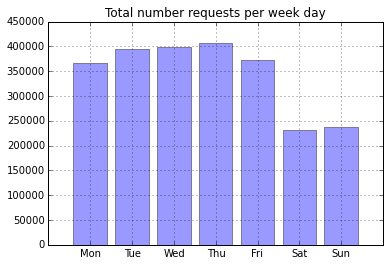

In [15]:
v_week_day = map(lambda x: x[0], hpwd)
v_cnt_hits = map(lambda x: x[1], hpwd)
v_week_day_ab = map(lambda x: week_day_map[x[0]], hpwd)

plt.bar(v_week_day, v_cnt_hits, align='center', alpha=0.4)
plt.xticks(v_week_day, v_week_day_ab)
plt.grid(True)
plt.title('Total number requests per week day')
plt.show()

#### Average number of hits (HTTP requests) by day of week Monday - Sunday.

In [16]:
q = ("SELECT  wday, hits_cnt/weeks_cnt AS avrg_hpd "
       "FROM ( "
             "SELECT week_day AS wday, COUNT(*) AS hits_cnt, COUNT(DISTINCT(date)) AS weeks_cnt "
             "  FROM weblog "
             " GROUP BY week_day "
             ") t2 "
     "ORDER BY wday "
     )

avg_hits_by_wday = sqlContext.sql(q).collect()
avg_hits_by_wday

[Row(wday=1, avrg_hpd=12188.333333333334),
 Row(wday=2, avrg_hpd=13130.433333333332),
 Row(wday=3, avrg_hpd=13322.166666666666),
 Row(wday=4, avrg_hpd=13108.90322580645),
 Row(wday=5, avrg_hpd=12049.516129032258),
 Row(wday=6, avrg_hpd=7452.032258064516),
 Row(wday=7, avrg_hpd=7691.225806451613)]

##### Visualize the average number of hits by day of week

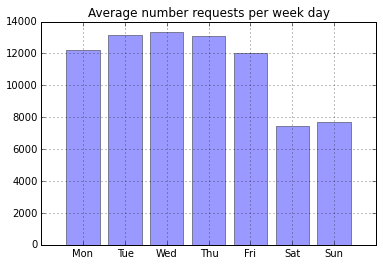

In [17]:
v_week_day = map(lambda x: x[0], avg_hits_by_wday)
v_cnt_hits = map(lambda x: x[1], avg_hits_by_wday)
v_week_day_ab = map(lambda x: week_day_map[x[0]], avg_hits_by_wday)

plt.bar(v_week_day, v_cnt_hits, align='center', alpha=0.4)
plt.xticks(v_week_day, v_week_day_ab)
plt.grid(True)
plt.title('Average number requests per week day')
plt.show()

#### Average count of requests per day by remote host (for the days a host was active). 

In [18]:
## Average count of hits per day for each remote host 
## (for the days a host was active) by remote host. Using sub-query.
#
q = ("SELECT  host, hits_cnt/days_cnt AS avrg_hpd "
       "FROM ( "
             "SELECT remote_host AS host, COUNT(*) AS hits_cnt, COUNT(DISTINCT(date)) AS days_cnt "
             "  FROM weblog "
             " GROUP BY remote_host "
             ") t2 "
     "ORDER BY avrg_hpd DESC "
     )

result = sqlContext.sql(q).collect()

#### Write the above result to CSV, and check out a few numbers. 

In [19]:
## write to CSV
#
write_to_csv('cnt_hits_per_day_by_host.csv', ['host', 'avrg_hpd'], result)

## Check out a few results
#
print 'Number distinct hosts: ', len(result)
result[0], result[1], result[999], result[9999]

Number distinct hosts:  162512


(Row(host=u'164.86.39.39', avrg_hpd=255.0),
 Row(host=u'br-b122-38.sheridanc.on.ca', avrg_hpd=249.0),
 Row(host=u'204.191.243.2', avrg_hpd=39.0),
 Row(host=u'slip35.vaxxine.com', avrg_hpd=15.0))

#### Count of requests per day and number distinct hosts per day for November and December 

In [20]:
## Count of requests per day and distinct hosts per day for November and December
#
q = ("SELECT date, week_day, COUNT(*) cnt_hits, COUNT(DISTINCT(remote_host)) cnt_hosts "
     "  FROM weblog "
     " WHERE month IN (11,12) "
     " GROUP BY date, week_day "
     " ORDER BY date" 
    )

result = sqlContext.sql(q).collect()

##### Save to CSV and visualize the result

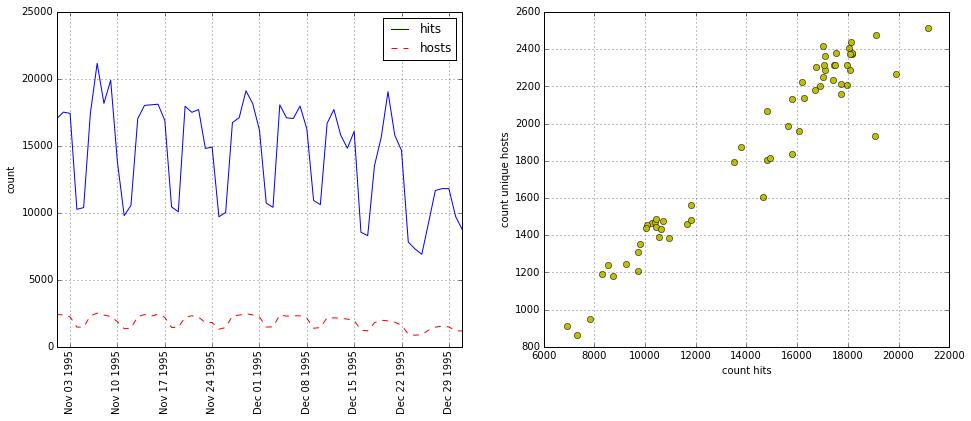

In [21]:
## Save to CSV and plot result
#

result2 = map(
    lambda x: ['%4d-%02d-%02d' % 
               (x.date.year, x.date.month, x.date.day), 
               week_day_map[x.week_day], 
               x.cnt_hits, 
               x.cnt_hosts], 
    result)

write_to_csv('cnt_requests_per_day_nov_dec.csv', ['date', 'week_day', 'cnt_hits', 'cnt_hosts'], result2)

v_date     = map(lambda x: datetime.date(x[0].year, x[0].month, x[0].day), result)
v_cnt_hits = map(lambda x: x[2], result)
v_cnt_hosts= map(lambda x: x[3], result)

fig1 = plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(v_date,v_cnt_hits,'b-',label='hits')
plt.plot(v_date,v_cnt_hosts,'r--',label='hosts')
plt.xticks(rotation='vertical')
plt.grid(True)
plt.legend(loc='upper right')
#plt.xlabel('day')
plt.ylabel('count')
plt.subplot(1,2,2)
plt.plot(v_cnt_hits, v_cnt_hosts, 'yo')
plt.grid(True)
plt.xlabel('count hits')
plt.ylabel('count unique hosts')
plt.show()
    

# for x in result2:
#     print '%s | %s | %5d | %5d' % tuple(x)


 * The first plot above visualizes how the traffic changes over time. It is higher on business days and drops on weekends. Then it tends to drop even more during the holiday season in the end of December.
 * The second plot illustrates the relationship between total number of requests and count distinct hosts for the same period of time. Visually it appears to be very close to linear.

#### Active hosts

Suppose we are interested in the most active hosts.
Here we are selecting hosts that have been online at least 25 different days.
Then we are registering a temporary table with columns host name (or IP) and number distinct days the host was active.

In [22]:
q = ("SELECT remote_host, COUNT(DISTINCT(date)) AS cnt "
     "  FROM weblog "
     " GROUP BY remote_host "
     "HAVING cnt >= 25 "
     " ORDER BY cnt DESC "
     )
hostMultiDayDf = sqlContext.sql(q)
hostMultiDayDf.registerTempTable('multi_day_hosts')
hostMultiDayDf.printSchema()

root
 |-- remote_host: string (nullable = true)
 |-- cnt: long (nullable = false)



#### Count of active hosts

In [23]:
sqlContext.sql("SELECT count(*) cnt FROM multi_day_hosts").collect()

[Row(cnt=1426)]

#### The 10 most active hosts by number of days online

In [24]:
## The 10 most active hosts by number of days online
#
res = sqlContext.sql(
    "SELECT * "
      "FROM multi_day_hosts "
    " ORDER BY cnt DESC "
    " LIMIT 10 ").collect()

for x in res:
    print '%3d %s' % (x[1], x[0])

214 broadway.sfn.saskatoon.sk.ca
214 sask.usask.ca
214 moondog.usask.ca
214 srv1.freenet.calgary.ab.ca
214 duke.usask.ca
212 freenet3.carleton.ca
210 ccn.cs.dal.ca
210 freenet2.carleton.ca
210 freenet.buffalo.edu
208 scn.org


#### Accessed URLs by host and date-time of access for the "active" hosts.

Now we will do a join with the two tables to select the sequence of URLs the ative hosts have accessed. We want them sorted by host and date-time of access. Showing the first 10 results.

In [25]:
q = ("SELECT w.remote_host, w.date_time, w.url "
     "  FROM  weblog w JOIN multi_day_hosts m ON w.remote_host=m.remote_host "
     " ORDER BY w.remote_host, w.date_time "
     )
result = sqlContext.sql(q)
result.count()

for x in result.take(10):
    print tuple(x)

(u'128.233.10.226', datetime.datetime(1995, 10, 24, 17, 52, 37), u'/')
(u'128.233.10.226', datetime.datetime(1995, 10, 24, 17, 52, 38), u'/images/logo.gif')
(u'128.233.10.226', datetime.datetime(1995, 10, 24, 17, 53, 29), u'/')
(u'128.233.10.226', datetime.datetime(1995, 10, 24, 17, 53, 31), u'/images/logo.gif')
(u'128.233.10.226', datetime.datetime(1995, 10, 24, 18, 3, 49), u'/')
(u'128.233.10.226', datetime.datetime(1995, 10, 24, 18, 3, 53), u'/images/logo.gif')
(u'128.233.10.226', datetime.datetime(1995, 10, 24, 18, 29, 24), u'/')
(u'128.233.10.226', datetime.datetime(1995, 10, 24, 18, 29, 27), u'/images/logo.gif')
(u'128.233.10.226', datetime.datetime(1995, 10, 25, 11, 13, 26), u'/')
(u'128.233.10.226', datetime.datetime(1995, 10, 25, 11, 13, 31), u'/images/logo.gif')


#### How many unique (distinct) URLs (endpoints) have been accessed in total? In fact, the number below includes also counts for same URL with distinct parameters. It does not mean that there are that many unique "pages".

In [26]:
q = ("SELECT COUNT(DISTINCT(url)) AS cnt_uniq_url "
     "  FROM weblog "
     )
sqlContext.sql(q).collect()

[Row(cnt_uniq_url=36522)]

#### The top 20 hosts by number of unuque URLs accessed for the full period of 7 months. Uniqueness is defined same way as above. If same endpoint is accessed with different parameters, it counts that many times for each unique set of parameters.

In [27]:
q = ("SELECT remote_host, COUNT(DISTINCT(url)) AS cnt_uniq_url "
     "  FROM weblog "
     " GROUP BY remote_host "
     " ORDER BY cnt_uniq_url DESC "
     " LIMIT 20"
     )
sqlContext.sql(q).collect()


[Row(remote_host=u'scooter.pa-x.dec.com', cnt_uniq_url=3938),
 Row(remote_host=u'duke.usask.ca', cnt_uniq_url=3390),
 Row(remote_host=u'cwis.usask.ca', cnt_uniq_url=2233),
 Row(remote_host=u'access.usask.ca', cnt_uniq_url=1472),
 Row(remote_host=u'sask.usask.ca', cnt_uniq_url=1286),
 Row(remote_host=u'skynet.usask.ca', cnt_uniq_url=1106),
 Row(remote_host=u'crimpshrine.atext.com', cnt_uniq_url=1070),
 Row(remote_host=u'broadway.sfn.saskatoon.sk.ca', cnt_uniq_url=935),
 Row(remote_host=u'herald.usask.ca', cnt_uniq_url=826),
 Row(remote_host=u'imhotep.usask.ca', cnt_uniq_url=821),
 Row(remote_host=u'explorer.sasknet.sk.ca', cnt_uniq_url=781),
 Row(remote_host=u'alf.usask.ca', cnt_uniq_url=773),
 Row(remote_host=u'grapes.usask.ca', cnt_uniq_url=769),
 Row(remote_host=u'muskat.usask.ca', cnt_uniq_url=732),
 Row(remote_host=u'204.62.245.32', cnt_uniq_url=674),
 Row(remote_host=u'mac40212.usask.ca', cnt_uniq_url=659),
 Row(remote_host=u'poppy.hensa.ac.uk', cnt_uniq_url=652),
 Row(remote_host

---